In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [5]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [6]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-4)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

  4%|██████████▏                                                                                                                                                                                                                             | 22/503 [00:02<00:43, 10.97it/s]

GOOGL 'date'


 11%|████████████████████████▍                                                                                                                                                                                                               | 53/503 [00:05<00:44, 10.21it/s]

AVB 'date'


 13%|█████████████████████████████                                                                                                                                                                                                           | 63/503 [00:06<00:38, 11.39it/s]

BRK.B 'date'


 15%|███████████████████████████████████▌                                                                                                                                                                                                    | 77/503 [00:07<00:36, 11.57it/s]

BF.B 'date'


 16%|████████████████████████████████████▍                                                                                                                                                                                                   | 79/503 [00:08<00:40, 10.38it/s]

BXP 'date'


 18%|█████████████████████████████████████████                                                                                                                                                                                               | 89/503 [00:08<00:34, 11.84it/s]

CCL 'date'


 25%|██████████████████████████████████████████████████████████▎                                                                                                                                                                            | 127/503 [00:12<00:37,  9.92it/s]

CPAY 'date'


 28%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 142/503 [00:14<00:32, 10.94it/s]

DAY 'date'


 29%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 144/503 [00:14<00:29, 12.22it/s]

DELL 'date'


 30%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 150/503 [00:15<00:36,  9.65it/s]

DLR 'date'


 36%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 179/503 [00:18<00:24, 13.47it/s]

EQR 'date'
ERIE 'date'
ESS 'date'


 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 183/503 [00:18<00:24, 13.26it/s]

EG 'date'


 38%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 193/503 [00:19<00:30, 10.17it/s]

FRT 'date'


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 213/503 [00:21<00:22, 12.64it/s]

GEV 'date'


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 262/503 [00:26<00:20, 11.65it/s]

IVZ 'date'
INVH 'date'


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 269/503 [00:27<00:26,  8.79it/s]

JCI 'date'


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 279/503 [00:28<00:20, 10.71it/s]

KIM 'date'


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 298/503 [00:30<00:20, 10.23it/s]

LYB 'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 322/503 [00:32<00:16, 10.84it/s]

MAA 'date'


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 348/503 [00:35<00:15,  9.76it/s]

NCLH 'date'


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 353/503 [00:36<00:15,  9.99it/s]

NXPI 'date'


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 365/503 [00:37<00:11, 11.51it/s]

PLTR 'date'


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 399/503 [00:41<00:10,  9.48it/s]

REG 'date'


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 409/503 [00:42<00:10,  9.37it/s]

RCL 'date'


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 413/503 [00:43<00:09,  9.90it/s]

SLB 'date'


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 462/503 [00:48<00:03, 10.97it/s]

UDR 'date'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 471/503 [00:49<00:02, 11.25it/s]

VLTO 'date'


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 477/503 [00:49<00:02, 12.84it/s]

VICI 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:52<00:00,  9.59it/s]

ZTS 'date'


In [7]:
factors_df = pd.concat(factors_df)

In [8]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [9]:
factors_df = factors_df.fillna(0)

In [68]:
start_year = 2015
end_year = 2022
sim_end_year = 2025

In [69]:
model = XGBRegressor()
factors = ["ptb","roa","mktcap","bm","short_debt","volume","divyield","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]>start_year) & (factors_df["year"]<end_year)].dropna()
sim = factors_df[(factors_df["year"]>=end_year) & (factors_df["year"]<sim_end_year)].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [70]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["expected_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_return"] - price["rf"])
        price["sigma"] = price["adjclose"].rolling(262).std()
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|█████████████████████████████                                                                                                                                                                                                           | 63/503 [00:05<00:37, 11.87it/s]

BRK.B 'date'


 16%|███████████████████████████████████▉                                                                                                                                                                                                    | 78/503 [00:06<00:33, 12.65it/s]

BF.B 'date'


 29%|███████████████████████████████████████████████████████████████████                                                                                                                                                                    | 146/503 [00:13<00:31, 11.29it/s]

DELL 'date'


 36%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 179/503 [00:16<00:26, 12.05it/s]

ERIE 'date'


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 365/503 [00:33<00:09, 13.86it/s]

PLTR 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:45<00:00, 11.01it/s]

ZTS 'date'


In [71]:
sim = pd.concat(prices).fillna(0)
sim["quarter"] = [x.quarter for x in sim["date"]]
sim = sim[(sim["date"]<datetime(sim_end_year,1,1)) & (sim["date"]>datetime(end_year,1,1))]

In [86]:
# Initialize variables
structure = {"stock":0.5,"bond":0.4,"option":0.1}
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "options": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)]
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                        option = Option.update(row, option)
                        position["options"][j] = option
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"] + option["pv"] + bond["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional * structure["stock"])
                            stock["sector"] = sector
                            position["stocks"][j] = stock
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            trades.append(option)
                            option = Option.buy(opportunity_row, option, notional * structure["option"])
                            option["sector"] = sector
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            trades.append(bond)
                            bond = Bond.buy(opportunity_row, bond, notional * structure["bond"])
                            bond["sector"] = sector
                            position["bonds"][j] = bond
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional * structure["stock"])
                        stock["sector"] = sector
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * structure["option"])
                        option["sector"] = sector
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * structure["bond"])
                        bond["sector"] = sector
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [87]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            for asset_class in ["stocks","bonds","options"]:
                view = state["positions"][i][asset_class][j]
                view["date"] = state["date"]
                view["asset_class"] = asset_class
            portfolios.append(state["positions"][i]["stocks"][j])
            portfolios.append(state["positions"][i]["options"][j])
            portfolios.append(state["positions"][i]["bonds"][j])

In [88]:
performance = pd.DataFrame(portfolios).pivot_table(index=["date","sector"],columns="asset_class",values="pv").reset_index().sort_values("date")
performance = performance.groupby(["date","sector"]).agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()
# performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

In [89]:
performance

asset_class,date,sector,stocks,bonds,options
0,2022-01-03,Communication Services,4545.454545,3636.363636,909.090909
1,2022-01-03,Consumer Discretionary,4545.454545,3636.363636,909.090909
2,2022-01-03,Consumer Staples,4545.454545,3636.363636,909.090909
3,2022-01-03,Energy,4545.454545,3636.363636,909.090909
4,2022-01-03,Financials,4545.454545,3636.363636,909.090909
...,...,...,...,...,...
7508,2024-09-20,Industrials,14007.413395,8806.759193,2201.689798
7509,2024-09-20,Information Technology,62849.690188,42156.549042,10539.137260
7510,2024-09-20,Materials,12095.460214,8444.790070,2117.796456
7511,2024-09-20,Real Estate,8126.237661,5522.132379,1380.533095


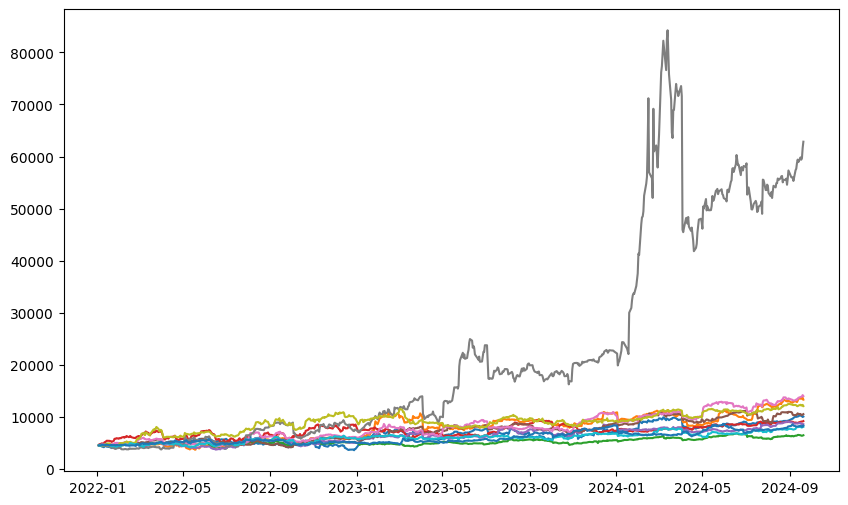

In [90]:
plt.figure(figsize=(10, 6))  
for sector in performance["sector"].unique():
    sector_perf = performance[performance["sector"]==sector]
    plt.plot(sector_perf["date"].values,sector_perf["stocks"].values)
    # plt.legend(performance["sector"].unique())
plt.show()

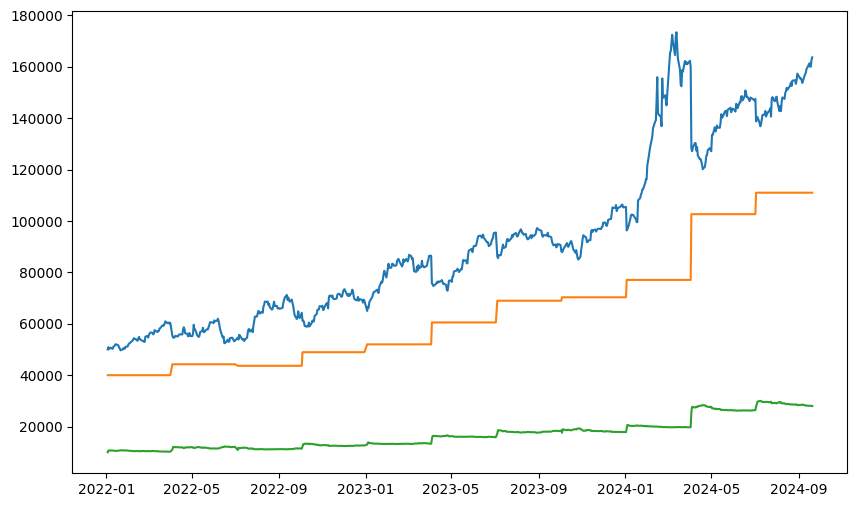

In [91]:
performance = performance.groupby(["date"]).agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stocks"].values)
plt.plot(performance["date"].values,performance["bonds"].values)
plt.plot(performance["date"].values,performance["options"].values)
plt.show()

In [92]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [93]:
visualization["pv"] = visualization["stocks"] + visualization["bonds"] + visualization["options"]
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

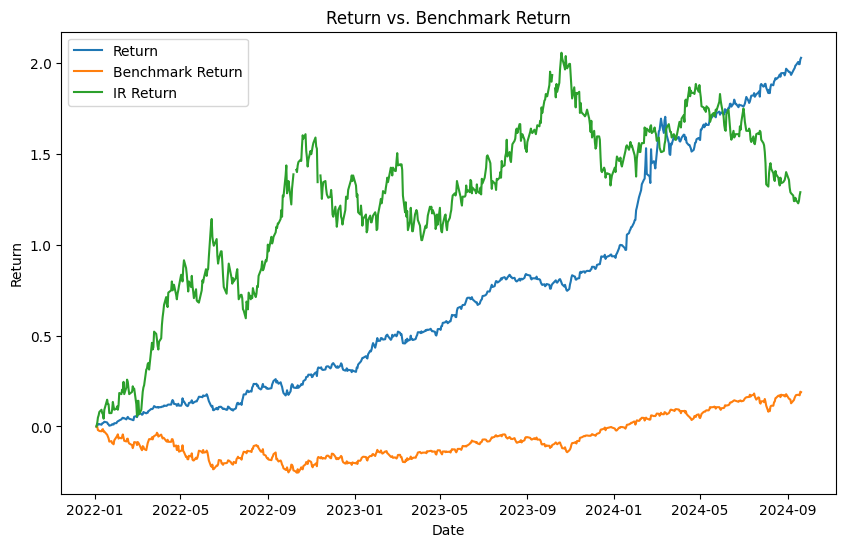

In [94]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [95]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

3.0362189028680704

In [96]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [97]:
t.sort_values("return",ascending=False).head(30)

,ticker,adjclose,quantity,buy_price,buy_date,sell_date,pv,sector,strike_price,premium,contract_price,notional,return,rate,GICS Sector,hpr
270,SMCI,1015.570000,70.905796,280.640000,2024-01-03,2024-04-03,72009.799386,Information Technology,NaN,NaN,NaN,NaN,2.618764,NaN,Information Technology,91
171,SMCI,255.000000,95.387243,109.460000,2023-04-04,2023-07-05,24323.746840,Information Technology,NaN,NaN,NaN,NaN,1.329618,NaN,Information Technology,92
72,FSLR,143.060000,65.333891,66.230000,2022-07-05,2022-10-04,9346.666436,Information Technology,NaN,NaN,NaN,NaN,1.160048,NaN,Information Technology,91
138,NVDA,27.438574,500.248609,14.305021,2023-01-03,2023-04-04,13726.108444,Information Technology,NaN,NaN,NaN,NaN,0.918108,NaN,Information Technology,91
150,TSLA,192.580000,51.578302,108.100000,2023-01-03,2023-04-04,9932.949416,Consumer Discretionary,NaN,NaN,NaN,NaN,0.781499,NaN,Consumer Discretionary,91
15,MOS,63.340638,119.883537,37.915586,2022-01-03,2022-04-04,7593.499793,Materials,NaN,NaN,NaN,NaN,0.670570,NaN,Materials,91
30,HAL,37.097398,198.755623,22.869565,2022-01-03,2022-04-04,7373.316428,Energy,NaN,NaN,NaN,NaN,0.622130,NaN,Energy,91
156,WBD,15.150000,476.498695,9.540000,2023-01-03,2023-04-04,7218.955235,Communication Services,NaN,NaN,NaN,NaN,0.588050,NaN,Communication Services,91
135,WST,346.939985,23.522473,233.457141,2023-01-03,2023-04-04,8160.886461,Health Care,NaN,NaN,NaN,NaN,0.486097,NaN,Health Care,91
288,META,505.763738,19.441632,343.439461,2024-01-03,2024-04-03,9832.872563,Communication Services,NaN,NaN,NaN,NaN,0.472643,NaN,Communication Services,91


In [98]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return").tail(50)

,GICS Sector,return,hpr
2,Consumer Staples,0.053122,91.2
9,Real Estate,0.079870,91.2
10,Utilities,0.084781,91.2
4,Financials,0.103161,91.2
3,Energy,0.123053,91.2
0,Communication Services,0.133752,91.2
1,Consumer Discretionary,0.155648,91.2
5,Health Care,0.167167,91.2
8,Materials,0.176495,91.2
6,Industrials,0.185730,91.2


In [99]:
performance

asset_class,date,stocks,bonds,options
0,2022-01-03,50000.000000,40000.000000,10000.000000
1,2022-01-04,50905.163331,40000.000000,10645.952974
2,2022-01-05,50230.895223,40000.000000,10719.027140
3,2022-01-06,50388.493066,40000.000000,10702.330540
4,2022-01-07,50695.413605,40000.000000,10661.806776
...,...,...,...,...
678,2024-09-16,161386.856291,111023.746918,28049.331232
679,2024-09-17,160083.687177,111023.746918,28116.190333
680,2024-09-18,160104.029250,111023.746918,28114.971915
681,2024-09-19,162795.165213,111023.746918,28011.712493
